# STAT3009 Project 2
| Name               | Student ID |
|--------------------|------------|
| LAW Yiu Leung Eric | 1155149315 |
| LAM Wai Chiu       | 1155152095 |
| TSOI Tung Sing     | 1155127274 |

# Import packages and load the developed methods
## Packages

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from numpy.linalg import norm
from datetime import datetime

from scipy.sparse import lil_matrix

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Load the existing methods

In [2]:
from developed_methods import *

In [3]:
import scipy as sp
from scipy.stats import chi2

def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

# save the predicted ratings to csv file
def save_csv(df, folder_path, method):
    nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")
    fileName = "{folder_path}/{method}_{nowTime}.csv".format(folder_path = folder_path, method = method, nowTime = nowTime)
    df.to_csv(fileName, index = False)


# Load Datasets

In [4]:
# Load dataset
train_rating = pd.read_csv("../data/train_rating.csv")
test_pair = pd.read_csv("../data/test_pair.csv")

item_feat = pd.read_csv("../data/item_feats.csv")
user_feat = pd.read_csv("../data/user_feats.csv")

sub = pd.read_csv('../predict/sample_submission.csv')

# EDA
This part is contributed by `Tsoi Tung Sing 1155149315` 
## Data Types
* UserId, ItemId : str
* rating : float 
* side information V1, V3 in item_feat are int -> Discrete Type RV
* side information V2 in item_feat is float -> Continuous Type RV
* side information V1 in user_feat is float -> Continuous Type RV
* side information V2, V3, V4 in user_feat are int -> Discrete Type RV

### test_pair

In [5]:
print('UserId data type: ' , type(test_pair['UserId'][0]) ) 
print('ItemId data type: ' , type(item_feat['ItemId'][0]) )
test_pair.head(3)

UserId data type:  <class 'str'>
ItemId data type:  <class 'str'>


,UserId,ItemId
0,DCC1A9,282298
1,895206,A9D3D8
2,C38E32,38D5EE


### item_feat

In [6]:
print('ItemId data type: ' , type(item_feat['ItemId'][0]) ) 
print('V1 data type: ' , type(item_feat['V1'][0]) )
print('V2 data type: ' , type(item_feat['V2'][0]) )
print('V3 data type: ' , type(item_feat['V3'][0]) )
item_feat.head(3)

ItemId data type:  <class 'str'>
V1 data type:  <class 'numpy.int64'>
V2 data type:  <class 'numpy.float64'>
V3 data type:  <class 'numpy.int64'>


,ItemId,V1,V2,V3
0,9AF5AA,8366,7.496452,2041
1,960857,10416,7.686800,1247
2,3FC7E9,1670,7.635397,1248


### train_rating

In [7]:
print('UserId data type: ' , type(train_rating['UserId'][0]) ) 
print('ItemId data type: ' , type(train_rating['ItemId'][0]) )
print('rating data type: ' , type(train_rating['rating'][0]) )
train_rating.head(3)

UserId data type:  <class 'str'>
ItemId data type:  <class 'str'>
rating data type:  <class 'numpy.float64'>


,UserId,ItemId,rating
0,A22818,70621F,0.0
1,36B488,16553B,0.0
2,AB1C55,035CDE,0.0


### user_feat

In [8]:
print('UserId data type: ' , type(user_feat['UserId'][0]) ) 
print('V1 data type: ' , type(user_feat['V1'][0]) )
print('V2 data type: ' , type(user_feat['V2'][0]) )
print('V3 data type: ' , type(user_feat['V3'][0]) )
print('V4 data type: ' , type(user_feat['V4'][0]) )
user_feat.head(3)

UserId data type:  <class 'str'>
V1 data type:  <class 'numpy.float64'>
V2 data type:  <class 'numpy.int64'>
V3 data type:  <class 'numpy.int64'>
V4 data type:  <class 'numpy.int64'>


,UserId,V1,V2,V3,V4
0,1CDE4D,NaN,5233,982,330
1,1FEE19,2.896804,6968,262,330
2,B14416,NaN,4787,1608,267


## No. of Users and Items

In [9]:
n_user = len(set(user_feat["UserId"]))
print("n_user in training =", n_user)
n_item = len(set(item_feat["ItemId"]))
print("n_item in training =", n_item)

n_user in training = 27000
n_item in training = 26000


## Check no. of users who didn't rate any item

In [10]:
no_rating_items = item_feat.set_index('ItemId').index.difference(train_rating.set_index('ItemId').index)
print("No. of no rating items:", len(no_rating_items) )

No. of no rating items: 5749


## Correlation between variables and rating
### Correlation between user features variables and rating 
* User_mean_ratings are not linear correlated with uesr features 
* V1, V2, V3, V4 in user features are not really linear correlated
* V1 and V4 has the highest correlation but still around 0.1 

In [11]:
# get user mean rating
user_mean = train_rating[['UserId','rating']].groupby(['UserId']).mean()
# concat features and rationg
user_mean_rating = pd.concat([user_mean, user_feat.set_index('UserId')], axis =1)
user_mean_rating.corr()

,rating,V1,V2,V3,V4
rating,1.000000,0.006956,-0.008383,-0.024794,0.073029
V1,0.006956,1.000000,-0.001254,-0.010570,0.101653
V2,-0.008383,-0.001254,1.000000,0.060035,-0.044762
V3,-0.024794,-0.010570,0.060035,1.000000,-0.004453
V4,0.073029,0.101653,-0.044762,-0.004453,1.000000


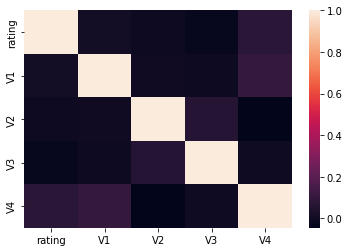

In [12]:
import seaborn as sns
ax = sns.heatmap(user_mean_rating.corr())

### item_feat side info variables
* Item_mean_ratings are not linear correlated with item features 
* V1, V2, V3 in item features are not linear correlated

In [13]:
# get item mean rating
item_mean = train_rating[['ItemId','rating']].groupby(['ItemId']).mean()
# concat features and rationg
item_mean_rating = pd.concat([item_mean, item_feat.set_index('ItemId')], axis =1)
item_mean_rating.corr()

,rating,V1,V2,V3
rating,1.000000,0.001805,0.004561,0.001998
V1,0.001805,1.000000,-0.007890,0.040643
V2,0.004561,-0.007890,1.000000,0.007543
V3,0.001998,0.040643,0.007543,1.000000


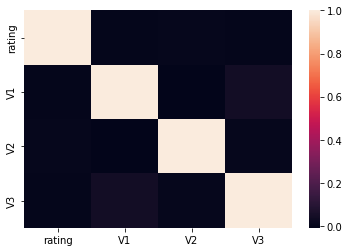

In [14]:
import seaborn as sns
ax = sns.heatmap(item_mean_rating.corr())

## Check na

In [16]:
pd.isna(train_rating).sum()

UserId    0
ItemId    0
rating    0
dtype: int64

In [17]:
pd.isna(user_feat).sum()

UserId        0
V1        10573
V2            0
V3            0
V4            0
dtype: int64

In [18]:
pd.isna(item_feat).sum()

ItemId    0
V1        0
V2        0
V3        0
dtype: int64

## Check infinity

In [19]:
# for train_rating
import math
n_inf = 0
for i in range(len(train_rating)):
    if ( math.isinf(train_rating.iloc[i,2]) ):
        n_inf = n_inf + 1
print('No. of infinity in train_rating :', n_inf)

No. of infinity in train_rating : 0


In [20]:
# for item_feat
for j in range(len(item_feat.columns) -1 ):
    n_inf = 0
    for i in range(len(item_feat)):
        if ( math.isinf(item_feat.iloc[i,j+1]) ):
            n_inf = n_inf + 1
    print('In V'+str(j+1), ', no. of n_inf :', n_inf)

In V1 , no. of n_inf : 0
In V2 , no. of n_inf : 417
In V3 , no. of n_inf : 0


In [21]:
# for user_feat
for j in range(len(user_feat.columns) -1 ):
    n_inf = 0
    for i in range(len(user_feat)):
        if ( math.isinf(user_feat.iloc[i,j+1]) ):
            n_inf = n_inf + 1
    print('In V'+str(j+1), ', no. of n_inf :', n_inf)

In V1 , no. of n_inf : 47
In V2 , no. of n_inf : 0
In V3 , no. of n_inf : 0
In V4 , no. of n_inf : 0


* No infinity in training rating
* 417 infinity in V2 of item features (1.6%)
* 47 infinity in V1 of user features (0.174%)

## Analsis on Rating

In [22]:
print('Max:', train_rating['rating'].max())
print('Min:', train_rating['rating'].min())

Max: 5.0
Min: 0.0


In [24]:
import warnings
warnings.filterwarnings("ignore")

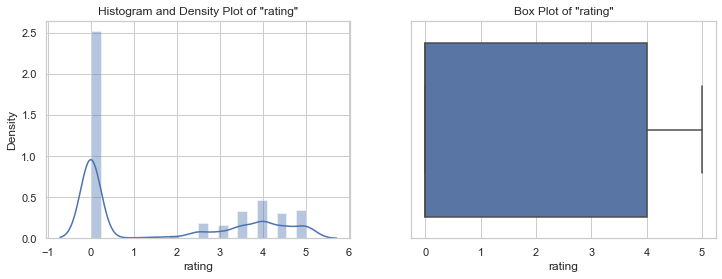

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of "rating"' )
axes[1].set_title('Box Plot of "rating"' )
sns.set_theme(style="whitegrid")
p = sns.distplot(train_rating['rating'],  hist=True, kde=True , ax=axes[0])
#p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=train_rating['rating'] , ax=axes[1])

### User mean rating (many users give only 0 rating)

In [26]:
p = user_mean['rating'].value_counts()[0]
print(p, '('+str(round(p /len(user_mean) * 100))+'%)', 'users only give 0 ratings')

1538 (27%) users only give 0 ratings


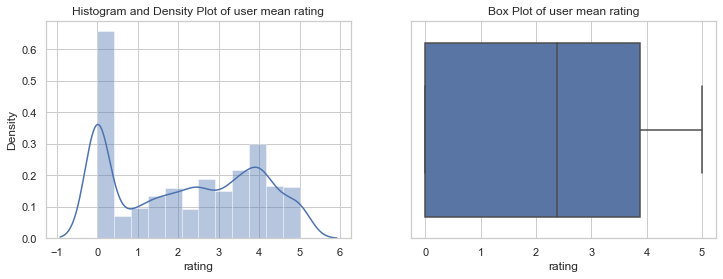

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of user mean rating' )
axes[1].set_title('Box Plot of user mean rating' )
sns.set_theme(style="whitegrid")
p = sns.distplot(user_mean['rating'],  hist=True, kde=True , ax=axes[0])
# p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=user_mean['rating'] , ax=axes[1])

### Item mean rating (many items only recieve mean rating 0)

In [28]:
p = item_mean['rating'].value_counts()[0]
print( p, '('+str(  round(p /len(item_mean) * 100))+'%)', 'items are only rated 0')

9286 (46%) items are only rated 0


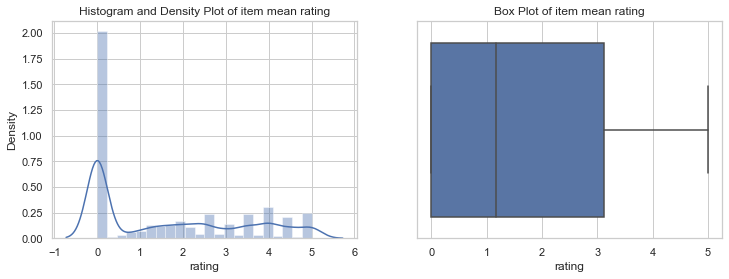

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of item mean rating' )
axes[1].set_title('Box Plot of item mean rating' )
sns.set_theme(style="whitegrid")
p = sns.distplot(item_mean['rating'],  hist=True, kde=True , ax=axes[0])
#p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=item_mean['rating'] , ax=axes[1])

### No. of rating each item received (Many outliers, the no. of rating can be differ greatly from item to item)

In [30]:
a = train_rating[['ItemId','rating']].copy()
a['number'] = [1]*len(train_rating)
print('Max no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].max())
print('Mean no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].mean())
print('Min no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].min())
print('sd of no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].std())

Max no. of rating in each item: 138
Mean no. of rating in each item: 1.9910621697693942
Min no. of rating in each item: 1
sd of no. of rating in each item: 2.7869305408712473


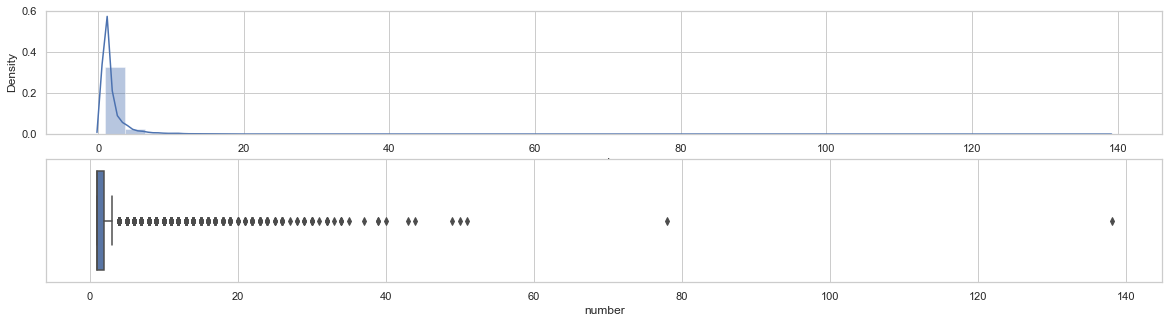

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(20,5) )

p = sns.distplot(a.groupby(['ItemId']).sum()['number'],  hist=True, kde=True, ax=axes[0])
box = sns.boxplot(x = a.groupby(['ItemId']).sum()['number'] , ax=axes[1])

### No. of rating each user gave (Even more outliers, the no. of rating can be differ greatly from user to user)

In [32]:
b = train_rating[['UserId','rating']].copy()
b['number'] = [1]*len(train_rating)
print('Max no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].max())
print('Mean no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].mean())
print('Min no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].min())
print('sd of no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].std())

Max no. of rating each user gave: 2670
Mean no. of rating each user gave: 6.992889351370101
Min no. of rating each user gave: 1
sd of no. of rating each user gave: 47.59377233828261


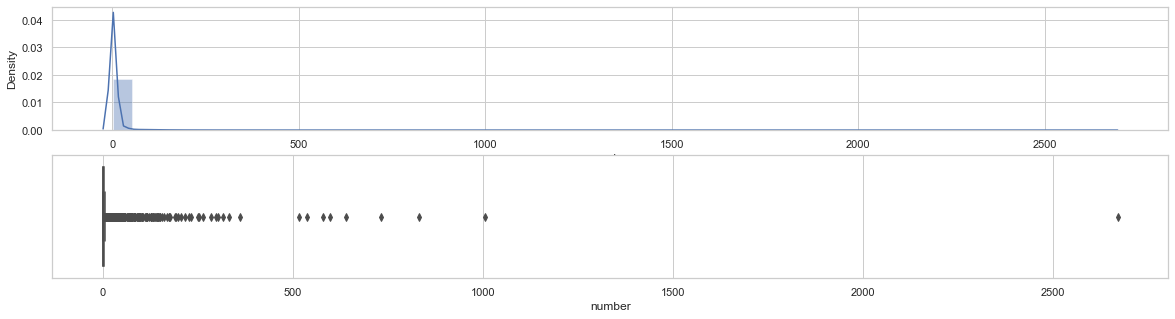

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(20,5) )

p = sns.distplot(b.groupby(['UserId']).sum()['number'],  hist=True, kde=True, ax=axes[0])
box = sns.boxplot(x = b.groupby(['UserId']).sum()['number'] , ax=axes[1])

### no. of rating does not correlate with rating

In [35]:
pd.concat([user_mean,b.groupby(['UserId']).sum()['number']], axis =1) .corr()

,rating,number
rating,1.000000,-0.048639
number,-0.048639,1.000000


In [36]:
pd.concat([item_mean, a.groupby(['ItemId']).sum()['number']], axis =1).corr()

,rating,number
rating,1.000000,0.011179
number,0.011179,1.000000


# Pre-processing
## Feature engineering
- check the `UserId` and `ItemId`: mapping `ItemId` to a continuous sequence based on `sklean.preprocessing`
- create `train_pair`,`train_rating`, `test_pair`
- handling missing value by mean
- handling -inf by min

In [5]:
# UserID
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(np.append(train_rating['UserId'], test_pair["UserId"]), user_feat["UserId"]))

user_feat['UserId'] = le_user.transform(user_feat["UserId"])
test_pair["UserId"] = le_user.transform(test_pair["UserId"])
train_rating['UserId'] = le_user.transform(train_rating["UserId"])

# ItemID
le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(np.append(train_rating['ItemId'], test_pair["ItemId"]), item_feat["ItemId"]))

item_feat['ItemId'] = le_item.transform(item_feat["ItemId"])
test_pair["ItemId"] = le_item.transform(test_pair["ItemId"])
train_rating['ItemId'] = le_item.transform(train_rating["ItemId"])

#Inf value
user_feat.loc[np.isinf(user_feat['V1']),'V1']=-3
item_feat.loc[np.isinf(item_feat['V2']),'V2']=2

# Missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(user_feat['V1'].values.reshape(-1, 1))
user_feat['V1'] = imp_mean.transform(user_feat['V1'].values.reshape(-1, 1))

## Create train pairs and test pairs

In [6]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
train_pair=train_rating.drop(columns='rating')

# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values

# number of users and items
# n_user, n_item = len(le_item.classes_), len(le_item.classes_)

## Check if some users rated same movie more than once

In [7]:
tmp = train_rating.sort_values(["UserId", "ItemId"])

# number of unique item ratings of each user
tmp_unique = tmp.groupby(["UserId"])["ItemId"].agg("unique").map(lambda x: len(x))
# number of ratings of each user
tmp_len = tmp.groupby(["UserId"])["ItemId"].agg("count")

n_user_train = len(set(train_rating["UserId"]))
print("n_user in dtrain =", n_user_train)
n_user_matched = sum(tmp_unique == tmp_len)
print("Number of matched ratins =", n_user_matched)

if(n_user_train == n_user_matched):
    print("There is no movies rated more than once by single user.")
else:
    print("There is {} users rated same movie again.".format(n_user_train - n_user_matched))

n_user in dtrain = 5766
Number of matched ratins = 5766
There is no movies rated more than once by single user.


In [8]:
temp_train_user=np.zeros((len(train_pairs[:,0]), 4))
temp_train_item=np.zeros((len(train_pairs[:,0]), 3))

temp_test_user=np.zeros((len(test_pairs[:,0]), 4))
temp_test_item=np.zeros((len(test_pairs[:,0]), 3))

for i in range(0,len(train_pairs[:,0])):
    temp_train_user[i,:]=user_feat.loc[np.where(train_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_train_item[i,:]=item_feat.loc[np.where(train_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]

for i in range(0,len(test_pairs[:,0])):
    temp_test_user[i,:]=user_feat.loc[np.where(test_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_test_item[i,:]=item_feat.loc[np.where(test_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]

In [9]:
temp_train_user=pd.DataFrame(temp_train_user,columns=['V1','V2','V3','V4'])
temp_train_item=pd.DataFrame(temp_train_item,columns=['V1','V2','V3'])
temp_test_user=pd.DataFrame(temp_test_user,columns=['V1','V2','V3','V4'])
temp_test_item=pd.DataFrame(temp_test_item,columns=['V1','V2','V3'])

user_pd_train = temp_train_user
item_pd_train = temp_train_item
user_pd_test = temp_test_user
item_pd_test = temp_test_item

## Detect outliers by using mahalanobis distance

In [10]:
df=pd.DataFrame(np.column_stack((user_pd_train,item_pd_train,train_ratings)))
outlier, md=mahalanobis_method(df)

In [11]:
# drop outliers
train_ratings=np.delete(train_ratings,[outlier], axis=0)
train_pairs=np.delete(train_pairs,[outlier], axis=0)
temp_train_user.drop(temp_train_user.index[outlier], inplace=True)
temp_train_item.drop(temp_train_item.index[outlier], inplace=True)
train_rating.drop(train_rating.index[outlier], inplace=True)

In [12]:
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

## Find the minimum and maximum of train_rating

In [24]:
class min_max_adj:
    def __init__(self, train_rating):
        self.min = np.min(train_rating)
        self.max = np.max(train_rating)
        self.true_rating = train_rating
    
    def adjust(self, pred_rating):
        pred_rating_adjusted = pred_rating.copy()
        pred_rating_adjusted[pred_rating > self.max] = self.max
        pred_rating_adjusted[pred_rating < self.min] = self.min
        return pred_rating_adjusted

    def rmse(self, pred_rating):
        return np.sqrt(np.mean((pred_rating - self.true_rating)**2))

adjustment = min_max_adj(train_rating["rating"])
print("Minmium and maximum:", [adjustment.min, adjustment.max])

Minmium and maximum: [0.0, 5.0]


## Pre-processing the dataset

All continuous features should be standardized as mean 0, std 1

In [13]:
## training data
## pre-processing for users
user_cont = ['V1','V2','V3','V4']
user_pd_train[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_train[user_cont])

## pre-processing for items
item_cont = ['V1','V2','V3']
item_pd_train[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_train[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_train.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_train.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4
15971 -0.125444 -0.516403 -0.852991  0.516165
12405 -0.965589 -1.117884  0.520429  0.516165
25875 -0.125444 -0.595934  0.314072  0.516165
13715 -0.711015  1.404077  0.529600  0.516165
13321 -1.241777 -0.854519 -1.806819 -2.381626
22496 -0.125444 -0.954910 -0.493013  0.516165
26658 -0.125444  0.323237  0.213186 -0.731789
33698 -0.222121 -1.243917  1.322928  0.516165
36868 -1.807230  0.334102 -0.513649  0.516165
21094 -0.125444  0.381907 -1.403276 -2.381626
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3
1994   0.727866 -0.120562 -1.373291
9284  -1.060878 -1.275878 -0.892460
24676  0.385838 -1.657762  0.748858
5397   1.13256

In [14]:
## testing data
## pre-processing for users
user_cont = ['V1','V2','V3','V4']
user_pd_test[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_test[user_cont])

## pre-processing for items
item_cont = ['V1','V2','V3']
item_pd_test[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_test[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_test.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4
16703  1.122796  1.287770 -1.343556  0.528364
14577 -0.660712  1.520811  1.537918 -2.689149
17341  1.036053 -1.732169  0.524828 -2.343292
13628 -1.494357 -0.068584  0.280132  0.528364
919    0.142862  0.542386 -0.861023  0.528364
16610 -1.526763 -1.291834  0.092607  0.528364
19253 -0.107994  0.788520 -1.940432 -2.930200
18448 -0.107994 -0.214344 -1.343556  0.528364
12479 -0.107994  1.048182  1.613385  0.528364
6259  -0.271714 -0.165903  1.306942  0.528364
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3
912   -1.077651 -0.092565 -0.883295
13949 -1.077651  0.222396 -0.882281
9082   1.240030  0.202956  1.471719
12865 -0.59662

# Method 1: ``LFM without side information``
## GLB+user mean+LFM 
* RMSE of training set = 1.619
* RMSE of testing set = (in Kaggle)

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.317, valid_rmse: 2.329
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.390, valid_rmse: 2.402
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.310, valid_rmse: 2.328
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.361, valid_rmse: 2.342
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.332, valid_rmse: 2.365
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.263, valid_rmse: 2.271
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.305, valid_rmse: 2.285
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.299, valid_rmse: 2.342
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.368, valid_rmse: 2.392
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.356, valid_rmse: 2.398
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.325, valid_rmse: 2.348
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.311, valid_rmse: 2.341
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.361, valid_rmse: 2.364
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.338, valid_rmse: 2.344
3-Fold

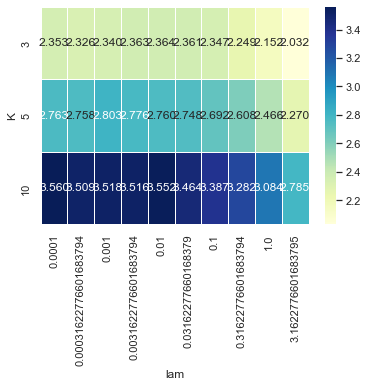

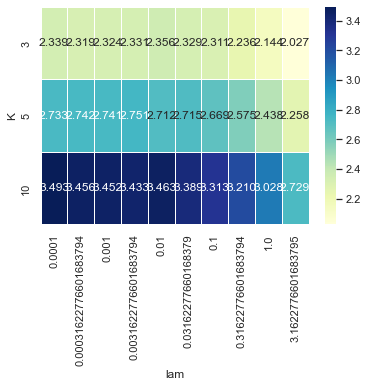

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.130 RMSE: 2.252
Reg-LFM: ite: 1; diff: 0.069 RMSE: 2.182
Reg-LFM: ite: 2; diff: 0.047 RMSE: 2.135
Reg-LFM: ite: 3; diff: 0.036 RMSE: 2.099
Reg-LFM: ite: 4; diff: 0.029 RMSE: 2.070
Reg-LFM: ite: 5; diff: 0.024 RMSE: 2.046
Reg-LFM: ite: 6; diff: 0.021 RMSE: 2.025
Reg-LFM: ite: 7; diff: 0.018 RMSE: 2.007
Reg-LFM: ite: 8; diff: 0.016 RMSE: 1.991
Reg-LFM: ite: 9; diff: 0.015 RMSE: 1.976


In [25]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred_glb = glb_ave.predict(test_pairs)
train_rating_cm = train_ratings - glb_ave.predict(train_pairs)

# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pairs)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pairs)
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred_user_mean + shiing.predict(test_pairs)
pred_rating = pred

In [20]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_LFM")

## user mean+item mean+LFM
* RMSE of training set = 
* RMSE of testing set = (in Kaggle)

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.055, valid_rmse: 2.064
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.008, valid_rmse: 2.030
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.079, valid_rmse: 2.120
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.242, valid_rmse: 2.245
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.104, valid_rmse: 2.100
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.088, valid_rmse: 2.032
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.031, valid_rmse: 2.015
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.984, valid_rmse: 2.043
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.301, valid_rmse: 2.328
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.127, valid_rmse: 2.169
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.029, valid_rmse: 2.033
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.102, valid_rmse: 2.093
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.024, valid_rmse: 2.067
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.060, valid_rmse: 2.061
3-Fold

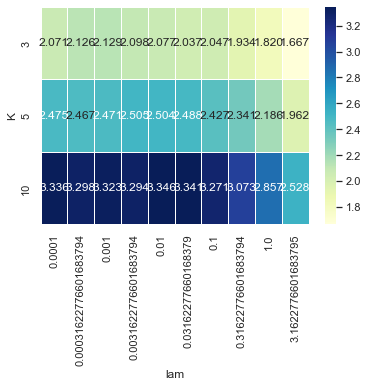

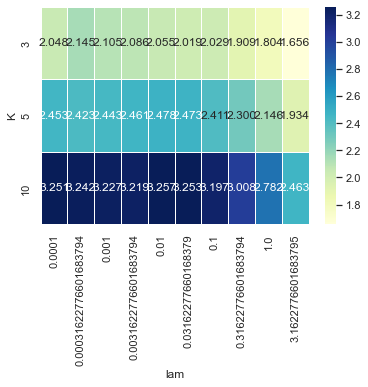

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.135 RMSE: 1.925
Reg-LFM: ite: 1; diff: 0.079 RMSE: 1.846
Reg-LFM: ite: 2; diff: 0.055 RMSE: 1.791
Reg-LFM: ite: 3; diff: 0.042 RMSE: 1.749
Reg-LFM: ite: 4; diff: 0.034 RMSE: 1.716
Reg-LFM: ite: 5; diff: 0.028 RMSE: 1.687
Reg-LFM: ite: 6; diff: 0.024 RMSE: 1.663
Reg-LFM: ite: 7; diff: 0.021 RMSE: 1.642
Reg-LFM: ite: 8; diff: 0.019 RMSE: 1.623
Reg-LFM: ite: 9; diff: 0.017 RMSE: 1.606


In [18]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred = user_ave.predict(test_pairs)

## item_mean
train_rating_cm = train_ratings - user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pairs)
pred = pred + item_ave.predict(test_pairs)


## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred + shiing.predict(test_pairs)
pred_rating = pred

In [22]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "user_item_LFM")

## GLB+user mean+item mean+LFM
* RMSE of training set = 

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.012, valid_rmse: 2.002
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.022, valid_rmse: 2.028
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.072, valid_rmse: 2.083
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 1.980, valid_rmse: 2.028
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.068, valid_rmse: 2.098
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.045, valid_rmse: 2.079
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.070, valid_rmse: 2.095
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.036, valid_rmse: 2.062
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.104, valid_rmse: 2.104
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.014, valid_rmse: 2.032
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.108, valid_rmse: 2.112
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.028, valid_rmse: 2.067
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.095, valid_rmse: 2.118
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.048, valid_rmse: 2.063
3-Fold

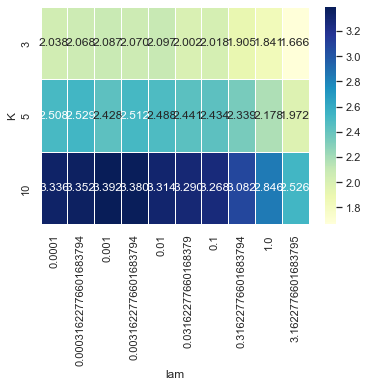

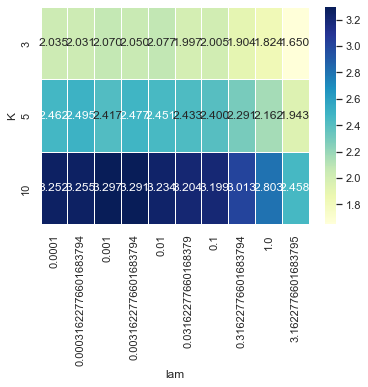

Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.189 RMSE: 1.930
Reg-LFM: ite: 1; diff: 0.080 RMSE: 1.851
Reg-LFM: ite: 2; diff: 0.053 RMSE: 1.797
Reg-LFM: ite: 3; diff: 0.040 RMSE: 1.757
Reg-LFM: ite: 4; diff: 0.033 RMSE: 1.724
Reg-LFM: ite: 5; diff: 0.028 RMSE: 1.696
Reg-LFM: ite: 6; diff: 0.024 RMSE: 1.672
Reg-LFM: ite: 7; diff: 0.021 RMSE: 1.651
Reg-LFM: ite: 8; diff: 0.019 RMSE: 1.631
Reg-LFM: ite: 9; diff: 0.017 RMSE: 1.614


In [24]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)
train_rating_res -= item_ave.predict(train_pairs)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pairs, train_rating_res)
pred = pred + shiing.predict(test_pairs)
pred_rating = pred

In [25]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_item_LFM")

# Method 2: ``Regression``: rating ~ user_features + item_features
## Step 1: generate `joint_feats` by emerge all user and item features

In [26]:
train_joint_feats=np.concatenate((user_pd_train.values, item_pd_train), axis=1)
test_joint_feats=np.concatenate((user_pd_test.values, item_pd_test.values), axis=1)

## Step 2: fit `regression`: rating ~ joint features  + `LFM`


In [27]:
reg = LinearRegression().fit(train_joint_feats, train_ratings)
reg_rating = reg.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

## Step 3: fit ``LFM`` after the regression

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.648, valid_rmse: 2.652
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.604, valid_rmse: 2.642
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.619, valid_rmse: 2.698
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.609, valid_rmse: 2.604
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.659, valid_rmse: 2.700
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.575, valid_rmse: 2.607
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.599, valid_rmse: 2.630
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.663, valid_rmse: 2.703
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.650, valid_rmse: 2.659
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.569, valid_rmse: 2.589
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.603, valid_rmse: 2.619
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.598, valid_rmse: 2.580
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.620, valid_rmse: 2.626
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.623, valid_rmse: 2.630
3-Fold

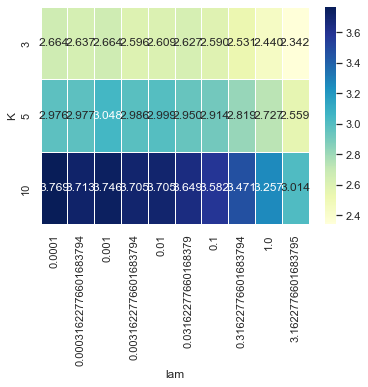

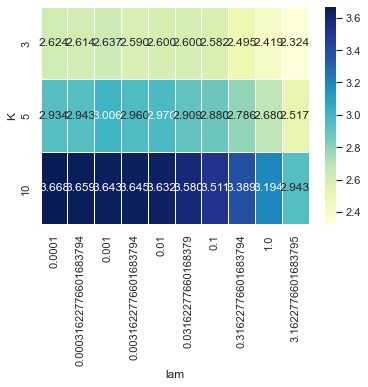

K             3.000000
lam           3.162278
train_rmse    2.324366
valid_rmse    2.342302
Name: 9, dtype: float64
Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.112 RMSE: 2.485
Reg-LFM: ite: 1; diff: 0.049 RMSE: 2.436
Reg-LFM: ite: 2; diff: 0.034 RMSE: 2.402
Reg-LFM: ite: 3; diff: 0.027 RMSE: 2.376
Reg-LFM: ite: 4; diff: 0.022 RMSE: 2.354
Reg-LFM: ite: 5; diff: 0.018 RMSE: 2.335
Reg-LFM: ite: 6; diff: 0.016 RMSE: 2.319
Reg-LFM: ite: 7; diff: 0.014 RMSE: 2.305
Reg-LFM: ite: 8; diff: 0.013 RMSE: 2.292
Reg-LFM: ite: 9; diff: 0.012 RMSE: 2.281


In [28]:
[3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_rating = reg_rating + shiing_best.predict(test_pairs)

In [30]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "reg_LFM")

# Method 3: ``RandomForest Regressor``: rating ~ user_features + item_features + `LFM`
## Step 1: fit `regression`: rating ~ joint features

In [31]:
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_reg=regressor.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

## Step 2: fit ``LFM`` after the RandomForest Regressor

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.564, valid_rmse: 2.579
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.566, valid_rmse: 2.588
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 2.587, valid_rmse: 2.644
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.539, valid_rmse: 2.581
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.607, valid_rmse: 2.595
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 2.600, valid_rmse: 2.623
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.540, valid_rmse: 2.558
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.653, valid_rmse: 2.656
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 2.641, valid_rmse: 2.679
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.605, valid_rmse: 2.634
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.566, valid_rmse: 2.602
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 2.623, valid_rmse: 2.644
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.593, valid_rmse: 2.598
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 2.616, valid_rmse: 2.628
3-Fold

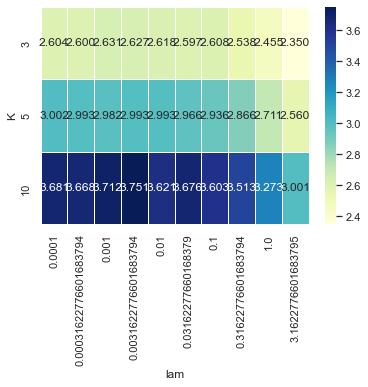

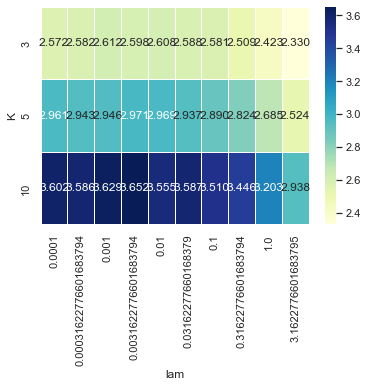

K             3.000000
lam           3.162278
train_rmse    2.330152
valid_rmse    2.349927
Name: 9, dtype: float64
Fitting Reg-LFM: K: 3, lam: 3.16228
Reg-LFM: ite: 0; diff: 0.244 RMSE: 2.510
Reg-LFM: ite: 1; diff: 0.063 RMSE: 2.447
Reg-LFM: ite: 2; diff: 0.040 RMSE: 2.406
Reg-LFM: ite: 3; diff: 0.030 RMSE: 2.376
Reg-LFM: ite: 4; diff: 0.024 RMSE: 2.352
Reg-LFM: ite: 5; diff: 0.020 RMSE: 2.332
Reg-LFM: ite: 6; diff: 0.017 RMSE: 2.315
Reg-LFM: ite: 7; diff: 0.015 RMSE: 2.300
Reg-LFM: ite: 8; diff: 0.013 RMSE: 2.286
Reg-LFM: ite: 9; diff: 0.012 RMSE: 2.274


In [32]:
[3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_rating = reg_rating + shiing_best.predict(test_pairs)

In [35]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "rf_reg_LFM")

# Method 4: ``RandomForest Regressor``

In [36]:
# fit the regressor using RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_rating=regressor.predict(test_joint_feats)

In [37]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "rf_reg")

# Method 5: ``GLB + user mean + item mean with sLFM`` without additional information
**WARNING: This method requires 2-3 hours computation time on normal computer**, these code is not deployed, but only showing in notebook.

In [38]:
pd.DataFrame(temp_train_user)['UserId']= train_pairs[:,0]
pd.DataFrame(temp_train_item)['ItemId']= train_pairs[:,1]

user_info = pd.DataFrame({'UserId': list(range(n_user))})
user_info = user_info.set_index('UserId')
user_info['V1'] = temp_train_user.groupby('UserId')['V1'].mean()
user_info['V2'] = temp_train_user.groupby('UserId')['V2'].mean()
user_info['V3'] = temp_train_user.groupby('UserId')['V3'].mean()
user_info['V4'] = temp_train_user.groupby('UserId')['V4'].mean()

## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)

item_info = pd.DataFrame({'ItemId': list(range(n_item))})
item_info = item_info.set_index('ItemId')
item_info['V1'] = temp_train_item.groupby('ItemId')['V1'].mean()
item_info['V2'] = temp_train_item.groupby('ItemId')['V2'].mean()
item_info['V3'] = temp_train_item.groupby('ItemId')['V3'].mean()

## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

In [40]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)

train_rating['res_rating'] = train_rating_res

## Cosine similarity

In [41]:
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [42]:
top = 5
index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pairs[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2


KeyboardInterrupt: 

In [ ]:
aug_pair, aug_rating_res = np.vstack((train_pairs, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pairs)
pred_rating = pred

In [ ]:
sub['rating'] = pred_rating
save_csv(sub, "../predict", "GLB_user_item_sLFM")

# Generate some additional side information for users and items
- Number of ratings
- Averaged ratings
- quantiles of the ratings

## Pre-processing the dataset
- combine with the given feature
- standardized as mean 0, std 1

In [26]:
pd.DataFrame(temp_train_user)['UserId']= train_pairs[:,0]
pd.DataFrame(temp_train_item)['ItemId']= train_pairs[:,1]

user_info = pd.DataFrame({'UserId': list(range(n_user))})
user_info = user_info.set_index('UserId')
user_info['mean'] = train_rating.groupby('UserId')['res_rating'].mean()
user_info['q1'] = train_rating.groupby('UserId')['res_rating'].quantile(.1)
user_info['q3'] = train_rating.groupby('UserId')['res_rating'].quantile(.3)
user_info['q5'] = train_rating.groupby('UserId')['res_rating'].quantile(.5)
user_info['q7'] = train_rating.groupby('UserId')['res_rating'].quantile(.7)
user_info['q9'] = train_rating.groupby('UserId')['res_rating'].quantile(.9)
user_info['V1'] = temp_train_user.groupby('UserId')['V1'].mean()
user_info['V2'] = temp_train_user.groupby('UserId')['V2'].mean()
user_info['V3'] = temp_train_user.groupby('UserId')['V3'].mean()
user_info['V4'] = temp_train_user.groupby('UserId')['V4'].mean()
user_info['Frequency'] = temp_train_user.groupby('UserId').size()
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)


item_info = pd.DataFrame({'ItemId': list(range(n_item))})
item_info = item_info.set_index('ItemId')
item_info['mean'] = train_rating.groupby('ItemId')['res_rating'].mean()
item_info['q1'] = train_rating.groupby('ItemId')['res_rating'].quantile(.1)
item_info['q3'] = train_rating.groupby('ItemId')['res_rating'].quantile(.3)
item_info['q5'] = train_rating.groupby('ItemId')['res_rating'].quantile(.5)
item_info['q7'] = train_rating.groupby('ItemId')['res_rating'].quantile(.7)
item_info['q9'] = train_rating.groupby('ItemId')['res_rating'].quantile(.9)
item_info['V1'] = temp_train_item.groupby('ItemId')['V1'].mean()
item_info['V2'] = temp_train_item.groupby('ItemId')['V2'].mean()
item_info['V3'] = temp_train_item.groupby('ItemId')['V3'].mean()
item_info['Frequency'] = temp_train_item.groupby('ItemId').size()
## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

KeyError: 'Column not found: res_rating'

# Method 6: ``GLB + user mean + item with SLFM`` with additional side information
**WARNING: This method requires 2-3 hours computation time on normal computer**, these code is not deployed, but only showing in notebook.

In [45]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)

train_rating['res_rating'] = train_rating_res

## Cosine similarity

In [157]:
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [158]:
top = 5
index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pairs[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0


KeyboardInterrupt: 

In [ ]:
aug_pair, aug_rating_res = np.vstack((train_pairs, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pairs)
pred_rating = pred

In [ ]:
sub['rating'] = pred_rating
sub.to_csv('predict/GLB_user_item_sLFM_add.csv', index=False)

# Method 7: ``NCF`` Model based on side information
This part is contributed by `LAW Yiu Leung Eric 1155149315`

In [37]:
# Import tensorflow library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [54]:
train_rating = pd.read_csv("../data/train_rating.csv")
test_pair = pd.read_csv("../data/test_pair.csv")

item_feat = pd.read_csv("../data/item_feats.csv")
user_feat = pd.read_csv("../data/user_feats.csv")

sub = pd.read_csv('../predict/sample_submission.csv')

In [55]:
# UserID
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(np.append(train_rating['UserId'], test_pair["UserId"]), user_feat["UserId"]))

user_feat['UserId'] = le_user.transform(user_feat["UserId"])
test_pair["UserId"] = le_user.transform(test_pair["UserId"])
train_rating['UserId'] = le_user.transform(train_rating["UserId"])

# ItemID
le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(np.append(train_rating['ItemId'], test_pair["ItemId"]), item_feat["ItemId"]))

item_feat['ItemId'] = le_item.transform(item_feat["ItemId"])
test_pair["ItemId"] = le_item.transform(test_pair["ItemId"])
train_rating['ItemId'] = le_item.transform(train_rating["ItemId"])

#Inf value
user_feat.loc[np.isinf(user_feat['V1']),'V1']=-3
item_feat.loc[np.isinf(item_feat['V2']),'V2']=2

# Missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(user_feat['V1'].values.reshape(-1, 1))
user_feat['V1'] = imp_mean.transform(user_feat['V1'].values.reshape(-1, 1))

In [56]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
train_pair=train_rating.drop(columns='rating')

# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values

# number of users and items
# n_user, n_item = len(le_item.classes_), len(le_item.classes_)
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

In [57]:
class min_max_adj:
    def __init__(self, train_rating):
        self.min = np.min(train_rating)
        self.max = np.max(train_rating)
        self.true_rating = train_rating
    
    def adjust(self, pred_rating):
        pred_rating_adjusted = pred_rating.copy()
        pred_rating_adjusted[pred_rating > self.max] = self.max
        pred_rating_adjusted[pred_rating < self.min] = self.min
        return pred_rating_adjusted

    def rmse(self, pred_rating):
        return np.sqrt(np.mean((pred_rating - self.true_rating)**2))

adjustment = min_max_adj(train_rating["rating"])
print("Minmium and maximum:", [adjustment.min, adjustment.max])

Minmium and maximum: [0.0, 5.0]


### Additonal features
additional features and {rating_mean, rating_count}  

### user_pd and item_pd
using outer join and fill missing data  
if no rating records, rating_count = 0 and rating_mean = glb_avg

In [58]:
## generate cont feats for users
user_pd = pd.merge(left=train_rating.groupby('UserId')['rating'].mean(), 
				   right=train_rating.groupby('UserId')['rating'].count(), on='UserId')
user_pd.columns = ['rating_mean', 'rating_count']
user_pd = pd.merge(left = user_feat, right = user_pd, on = "UserId", how = "outer") # using outer join

## handle missing data
# if the user has no rating record, set rating_count = 0
user_pd.fillna(value = {"rating_count": 0}, inplace = True)
# if the rating_mean is missing, then use global mean
imp_mean.fit(user_pd)
user_pd = pd.DataFrame(imp_mean.transform(user_pd), columns = user_pd.columns)

## generate cont feats for items
item_rating_pd = pd.merge(left=train_rating.groupby('ItemId')['rating'].mean(), 
						  right=train_rating.groupby('ItemId')['rating'].count(), on='ItemId')
item_rating_pd.columns	= ['rating_mean', 'rating_count']
item_pd = pd.merge(left=item_feat, right=item_rating_pd, on='ItemId', how = "outer") # using outer join

## handle missing data
# if the item has no rating record, set rating_count = 0
item_pd.fillna(value = {"rating_count": 0}, inplace = True)
# if the rating_mean is missing, then use global mean
imp_mean.fit(item_pd)
item_pd = pd.DataFrame(imp_mean.transform(item_pd), columns = item_pd.columns)


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')

print(user_pd.sample(10))
print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')

print(item_pd.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
        UserId        V1      V2      V3     V4  rating_mean  rating_count
4728   20037.0  3.423729  6115.0   755.0  154.0     2.211891           0.0
5510   12439.0  3.690928  5095.0  1147.0  154.0     2.211891           0.0
21483   4266.0  3.034468  4296.0  1591.0  330.0     1.500000          37.0
12855  19488.0  3.438890  6563.0    77.0  290.0     2.211891           0.0
25699  10710.0  3.423729  2914.0  1072.0  330.0     3.600000           5.0
10984   9933.0  3.624002  6776.0   439.0  325.0     1.750000           8.0
5354   24519.0  3.423729   397.0   439.0  325.0     2.211891           0.0
16623    594.0  3.047028  4118.0     1.0    0.0     2.211891           0.0
17751  19556.0  3.423729  5779.0  1087.0  330.0     2.211891           0.0
15263  26746.0  3.873911  7383.0   233.0   56.0     2.211891           0.0
#######

### Standardize continous features

In [59]:
## pre-processing for users
user_cont = ["V1", "V2", "V3", "V4", "rating_mean", "rating_count"]
user_pd[user_cont] = StandardScaler().fit_transform(user_pd[user_cont])

## pre-processing for item
item_cont = ["V1", "V2", "V3", "rating_mean", "rating_count"]
item_pd[item_cont] = StandardScaler().fit_transform(item_pd[item_cont])


user_pd = user_pd.set_index('UserId', drop=True)
item_pd = item_pd.set_index('ItemId', drop=True)

print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
               V1        V2        V3        V4   rating_mean  rating_count
UserId                                                                     
6365.0  -0.468895 -1.478170 -1.133611  0.412484 -5.564071e-16     -0.067335
15666.0 -1.124293  0.904072 -1.216042  0.762978  9.874358e-01     -0.022246
3343.0  -0.363988 -0.796624  1.060836  0.719167 -5.564071e-16     -0.067335
24403.0 -0.362612  1.183367 -1.572501  0.762978 -5.564071e-16     -0.067335
11983.0  0.000000  0.407596  0.388021  0.762978 -5.564071e-16     -0.067335
9168.0   1.540847  1.621111 -0.745963  0.762978 -1.518399e+00      0.067933
5013.0  -1.213029  0.049287 -1.216042  0.762978 -5.564071e-16     -0.067335
13915.0 -0.086388  1.365479  0.755619 -0.779197 -5.564071e-16     -0.067335
13843.0 -0.863029 -0.562118 -1.572501  0.762978 -5.564071e-16     -0.067

## NCF model
only two embeddings for categorical features, UserId and ItemId.

In [44]:
class SideNCF(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(SideNCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.itme_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )

        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        cont_feats = inputs[0]
        cate_feats = inputs[1]

        user_vector = self.user_embedding(cate_feats[:,0])
        itme_vector = self.itme_embedding(cate_feats[:,1])

        concatted_vec = self.concatenate([cont_feats, user_vector, itme_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [45]:
model = SideNCF(num_users=n_user, num_items=n_item, embedding_size=50)

metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

## Find the continuous features and categorical features for user and item, respectively
cate_feats = ["UserId", "ItemId"]

In [46]:
item_cont = ["V1", "V2", "V3", 'rating_mean', 'rating_count']
user_cont = ["V1", "V2", "V3", "V4", 'rating_mean', 'rating_count']

train_cont_feats = np.hstack((user_pd.loc[train_pairs[:,0]][user_cont], item_pd.loc[train_pairs[:,1]][item_cont]))
train_cate_feats = train_pairs.copy()

test_cont_feats = np.hstack((user_pd.loc[test_pairs[:,0]][user_cont], item_pd.loc[test_pairs[:,1]][item_cont]))
test_cate_feats = test_pairs.copy()

## Fit the model

In [47]:
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=[train_cont_feats, train_cate_feats],
    y=train_ratings,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_split=.2,
)

Epoch 1/50
504/504 [==============================] - 17s 30ms/step - loss: 1.9152 - mae: 0.8888 - rmse: 1.3624 - val_loss: 1.5440 - val_mae: 0.7653 - val_rmse: 1.2270
Epoch 2/50
504/504 [==============================] - 15s 30ms/step - loss: 1.5485 - mae: 0.7556 - rmse: 1.2265 - val_loss: 1.4762 - val_mae: 0.7262 - val_rmse: 1.1967
Epoch 3/50
504/504 [==============================] - 14s 28ms/step - loss: 1.5044 - mae: 0.7341 - rmse: 1.2071 - val_loss: 1.5658 - val_mae: 0.7387 - val_rmse: 1.2318
Epoch 4/50
504/504 [==============================] - 15s 29ms/step - loss: 1.4836 - mae: 0.7238 - rmse: 1.1956 - val_loss: 1.4422 - val_mae: 0.7258 - val_rmse: 1.1801
Epoch 5/50
504/504 [==============================] - 14s 29ms/step - loss: 1.4262 - mae: 0.7089 - rmse: 1.1711 - val_loss: 1.4334 - val_mae: 0.7123 - val_rmse: 1.1746
Epoch 6/50
504/504 [==============================] - 15s 30ms/step - loss: 1.4296 - mae: 0.7043 - rmse: 1.1686 - val_loss: 1.5095 - val_mae: 0.7154 - val_rmse:

## Result of training dataset
the result is adjusted for min=0, max=5

In [48]:
pred_rating = model.predict([train_cont_feats, train_cate_feats]).flatten()
pred_rating = adjustment.adjust(pred_rating)
print(pred_rating)
print('rmse: SideNCF: %.3f' %rmse(train_ratings, pred_rating))

[0.       0.       0.       ... 0.       0.       4.695835]
rmse: SideNCF: 0.840


## Save prediction

In [49]:
pred = model.predict([test_cont_feats, test_cate_feats]).flatten()
pred = adjustment.adjust(pred)
sub["rating"] = pred
save_csv(sub, "../predict", "NCF")

# Result
## Print T-th record
Take T=9315

In [50]:
t = 9315

print("T-th test_pair: ", test_pairs[t])
print("T-th predicted rating: ", pred[t])

T-th test_pair:  [ 2073 11608]
T-th predicted rating:  1.99398


## Print Top-5 Preferred Items based on `pred_rating`

In [52]:
user_id_t = test_pairs[t, 0]
index = train_pair[train_pair["UserId"] == user_id_t].index
pred_t = pd.DataFrame({"item_id": train_pair["ItemId"][index], "rating": pred_rating[index]})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
